# Interactias Geo Selected Network

One way of examining the impact of invasive species is to look at all their interactions and the interations those organisms have with each other. This full interaction network gives you an indication of whether a species might be a "keystone" species and therefore have a disproportionatly large impact.

In this step of the evolution of this script it will be adapted to quantify species by their occupancy.

I will harvest species interactions data from GloBI (https://www.globalbioticinteractions.org/) to discover the species that interact with an invasive species.
I will then harvest all the interactions for those species to create two tiers of interactions.
I will then count all the occurences of these in species in the Belgian datacube.
I will then visualize this.

This notebook takes considerable insperation and code from Yikang Li's project on GloBI (https://curiositydata.org/part1_globi_access/).


### For information: This is the list of invasive alien species of Union concern
|A|H|O|
|--|--|--|
|Acacia saligna|Heracleum sosnowskyi|Orconectes virilis|
|Acridotheres tristis|Herpestes javanicus|Oxyura jamaicensis|
|Ailanthus altissima|Humulus scandens|Pacifastacus leniusculus|
|Alopochen aegyptiaca|Hydrocotyle ranunculoides|Parthenium hysterophorus|
|Alternanthera philoxeroides|Impatiens glandulifera|Pennisetum setaceum|
|Andropogon virginicus|Lagarosiphon major|Perccottus glenii|
|Arthurdendyus triangulatus|Lepomis gibbosus|Persicaria perfoliata|
|Asclepias syriaca|Lespedeza cuneata|Plotosus lineatus|
|Baccharis halimifolia|Lithobates catesbeianus|Procambarus clarkii|
|Cabomba caroliniana|Ludwigia grandiflora|Procambarus fallax|
|Callosciurus erythraeus|Ludwigia peploides|Procyon lotor|
|Cardiospermum grandiflorum|Lygodium japonicum|Prosopis juliflora|
|Cortaderia jubata|Lysichiton americanus|Pseudorasbora parva|
|Corvus splendens|Microstegium vimineum|Pueraria montana|
|Ehrharta calycina|Muntiacus reevesi|Salvinia molesta|
|Eichhornia crassipes|Myocastor coypus|Sciurus carolinensis|
|Elodea nuttallii|Myriophyllum aquaticum|Sciurus niger|
|Eriocheir sinensis|Myriophyllum heterophyllum|Tamias sibiricus|
|Gunnera tinctoria|Nasua nasua|Threskiornis aethiopicus|
|Gymnocoronis spilanthoides|Nyctereutes procyonoides|Trachemys scripta|
|Heracleum mantegazzianum|Ondatra zibethicus|Triadica sebifera|
|Heracleum persicum|Orconectes limosus|Vespa velutina|

In [232]:
import sys
print(sys.version)

#Python 3.7.4 (default, Aug 9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
#pygbif 0.3.0

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


In [233]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pygbif import species
from pygbif import occurrences as occ
import sqlite3
from sqlite3 import Error
import pydot
import math

### Setting up some parameters

In [234]:
# There is no point accepting all the species that have more than one record.
# There are too many casual records of plants and birds
thresholdForOccNum = 5
# If you want to exclude an interaction add it here
#interactionsToExclude = "visitsFlowersOf" #If you're not intersted in pollinators this will remove most of them
interactionsToExclude = "interactsWith"    #Many interactions in GloBI do not specify a specific interaction. You can get a cleaner netwot by excluding them
#interactionsToExclude = ""

In [235]:

## Define the country of interest
country  = 'Belgium'

## The occurrence cube has data for each year, but here we aggreagate years to get a more complete measure of occupancy.
## This parameter defines the year from where to consider records for the occupancy
year = 2000

## Define the place to find the data cube for occupancy data
## Currently the cube contains only Belgian data so that is all that can be used
database = r"..\..\data\cube.db" 

## Define the place to find the interaction data
globiDB = r"..\..\createGlobiDB\globi.db"

### Define the taxon for the notebook for which to find all interactions


In [236]:
taxon=input()

Muntiacus reevesi


In [237]:
taxon = taxon.strip()

## Check to see if the taxon exits in GBIF

In [238]:
try:
    #NOTE: The function method name_suggest has a different behavior with regards to the gender of Latin names to name_backbone
    # If name_backbone is given a name in one gender it can still return the best match from the GBIF backbone if that
    # name is spelled as if it was another gender.
    #key = species.name_suggest(q=taxon, limit = 1)
    match = species.name_backbone(name=taxon, limit = 1)
    #print(key)
    
    # if there is no match this is returned form .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
    if match['matchType'] == 'NONE':
        raise ValueError("TAXON NOT FOUND ON GBIF!")
    else:
        key = match['usageKey']
except ValueError as ve:
    print(ve)
    exit(1)




In [239]:
fullScientificName = match['scientificName']
print('The taxon to be studied is ' + fullScientificName)


The taxon to be studied is Muntiacus reevesi (Ogilby, 1839)


### Just for information take a look at the interactions that the taxon has

In [240]:
# What are all the types of interactions involving taxon as source taxon?
#data[data['sourceTaxonName'] == taxon]['interactionTypeName'].unique()
try:
    connGlobi = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [241]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName, COUNT(interactionTypeName) from globi  WHERE sourceTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
sourceInteractions = curGlobi.fetchall()

In [242]:
sourceInteractions

[('eats', 7), ('interactsWith', 81)]

In [243]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName, COUNT(interactionTypeName) from globi  WHERE targetTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
targetInteractions = curGlobi.fetchall()
targetInteractions

[('ectoparasiteOf', 6),
 ('hasHost', 1),
 ('interactsWith', 27),
 ('parasiteOf', 18)]

## Get the primary interation data for the species in question

This is limited to the rank of species because otherwise the network can get very large with rather irrelivent higher taxa.
However, if no interactions are found at the species level it might be worth removing this restriction.

In [244]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE targetTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
interactDataTaxon = curGlobi.fetchall()

In [245]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE sourceTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
sources = curGlobi.fetchall()

In [246]:
interactDataTaxon.extend(sources)
len(interactDataTaxon)

32

In [247]:
# Convert to a Pandas dataframe
interactDataTaxon = pd.DataFrame(interactDataTaxon)

In [248]:
# Add column names
interactDataTaxon
interactDataTaxon.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName', \
                                'sourceSexId', 'sourceSexName','interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName',\
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

## Get a list of all the primary interacting species

In [249]:
interactingTaxaData = interactDataTaxon.drop_duplicates()

In [250]:
primaryInteractingTaxa = interactingTaxaData['sourceTaxonName'].drop_duplicates()
len(primaryInteractingTaxa)

9

In [251]:
primaryInteractingTaxa = (primaryInteractingTaxa.append(interactingTaxaData['targetTaxonName']).drop_duplicates())
len(primaryInteractingTaxa)

16

In [252]:
primaryInteractingTaxa

0         Solenopotes muntiacus
1                     Damalinia
2                 Ixodes ovatus
3            Haemaphysalis yeni
4        Cryptosporidium parvum
5           Mycobacterium bovis
8        Tricholipeurus indicus
24         Gongylonema pulchrum
25            Muntiacus reevesi
25               Arum maculatum
26          Cardamine pratensis
27             Anemone nemorosa
28         Dactylorhiza fuchsii
29               Orchis mascula
30         Mercurialis perennis
31    Hyacinthoides non-scripta
dtype: object

## A function to query the globi database

In [253]:
def secondaryDataInGlobi(conn, intaxon):
    cur = conn.cursor()
    if interactionsToExclude == "":
        cur.execute("SELECT * from globi  WHERE (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?);", \
                 (intaxon,intaxon,))
    else:
        cur.execute("SELECT * from globi where (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?) and interactionTypeName NOT IN (?);", \
                (intaxon,intaxon,interactionsToExclude,))
    return(cur.fetchall())

## Get all the secondary interactions

In [254]:
try:
    conn = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [255]:
secondarylist = []

for name in primaryInteractingTaxa:
    temp = secondaryDataInGlobi(conn, name)
    secondarylist.extend(temp)

In [256]:
# Convert to a Pandas dataframe
secondarylist = pd.DataFrame(secondarylist)

In [257]:
secondarylist.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName',\
                                'sourceSexId', 'sourceSexName', 'interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName', \
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

In [258]:
allInteractionsData = interactingTaxaData.append(secondarylist)

In [259]:
allInteractionsData = allInteractionsData.drop_duplicates()


In [260]:
    cleanInteractDataTaxon = allInteractionsData[['sourceTaxonId', 'sourceTaxonName', 'sourceTaxonSpeciesName', 'sourceTaxonRank',
        'sourceTaxonFamilyName', 'interactionTypeName',
        'targetTaxonName','targetTaxonSpeciesName','targetTaxonRank', 'sourceCitation', 'sourceDOI',
        'sourceTaxonKingdomName','sourceTaxonKingdomId', 'targetTaxonKingdomName','targetTaxonKingdomId'                                        
        ]].dropna(subset=['targetTaxonSpeciesName','sourceTaxonSpeciesName'])

In [261]:
allSourceInteractingTaxa = cleanInteractDataTaxon['sourceTaxonSpeciesName'].drop_duplicates()
allTargetInteractingTaxa = cleanInteractDataTaxon['targetTaxonSpeciesName'].drop_duplicates()

In [262]:
allInteractingTaxa = allSourceInteractingTaxa.append(allTargetInteractingTaxa).drop_duplicates()
allInteractingTaxa.count()

258

In [263]:
allInteractingTaxa.head()

0     Solenopotes muntiacus
1                          
2             Ixodes ovatus
3        Haemaphysalis yeni
4    Cryptosporidium parvum
dtype: object

In [264]:
# How many different sort of interaction do I have left?
# Checking out all the interaction types
cleanInteractDataTaxon.groupby(cleanInteractDataTaxon['interactionTypeName']).size().sort_values(ascending = False)

interactionTypeName
hasHost            2108
parasiteOf          438
eats                103
endoparasiteOf       36
visitsFlowersOf      11
pollinates            8
preysOn               6
ectoparasiteOf        6
livesOn               4
pathogenOf            1
dtype: int64

### This function takes a name string and checks on GBIF to see if the name exists there.

In [265]:
def speciesExistsInGBIF(name, rank):
    try:
        match = species.name_backbone(name=name, rank=rank, limit = 1)

        # if there is no match this is returned from .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
        if match['matchType'] == 'NONE':
            return False
        else:
            return match
    except ValueError as ve:
        print(ve)
        exit(1)

### Check that the species in question is actually found on GBIF

In [266]:
if(speciesExistsInGBIF(taxon, "species") == False):
    print("##### {0} has not been found on GBIF #####".format(taxon))

### Citation for the GBIF Backbone Taxonomy

In [267]:
from datetime import date
print("GBIF Secretariat (2019). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on ", date.today())

GBIF Secretariat (2019). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on  2020-07-23


### Check to see which taxa in the interaction network are found in GBIF and list those ones that are not

In [268]:
taxaFound = {}
kingdom = {}

print('Taxa from GLoBI, but not found in GBIF')
for name in allInteractingTaxa.items():
    GBIFName = speciesExistsInGBIF(name[1], "species")
    if GBIFName == False:
        taxaFound[name[1]] = False
        print(name[1])
    else:
        taxaFound[name[1]] = GBIFName['usageKey']
        kingdom[name[1]] = GBIFName['kingdom']

    

Taxa from GLoBI, but not found in GBIF

PIG, GUINEA
Hyobates mulleri


In [269]:
# Convert to a Pandas dataframe
taxaFound = pd.DataFrame.from_dict(taxaFound, orient='index')

In [270]:
len(taxaFound)

258

In [271]:
kingdom

{'Solenopotes muntiacus': 'Animalia',
 'Ixodes ovatus': 'Animalia',
 'Haemaphysalis yeni': 'Animalia',
 'Cryptosporidium parvum': 'Chromista',
 'Mycobacterium bovis': 'Bacteria',
 'Tricholipeurus indicus': 'Animalia',
 'Gongylonema pulchrum': 'Animalia',
 'Muntiacus reevesi': 'Animalia',
 'Anaplasma phagocytophilum': 'Bacteria',
 'Borrelia sinica': 'Bacteria',
 'Cryptosporidium parvum virus 1': 'Viruses',
 'Psychoda phalaenoides': 'Animalia',
 'Psychoda grisescens': 'Animalia',
 'Melampsora allii-populina': 'Fungi',
 'Ascochyta ari': 'Fungi',
 'Puccinia sessilis': 'Fungi',
 'Lilioceris lilii': 'Animalia',
 'Melanustilospora ari': 'Fungi',
 'Arum maculatum': 'Plantae',
 'Ramularia cardamines': 'Fungi',
 'Peronospora parasitica': 'Chromista',
 'Erysiphe cruciferarum': 'Fungi',
 'Ceutorhynchus pervicax': 'Animalia',
 'Ceutorhynchus cochleariae': 'Animalia',
 'Eurydema dominulus': 'Animalia',
 'Bruchus loti': 'Animalia',
 'Pieris rapae': 'Animalia',
 'Pieris napi': 'Animalia',
 'Anthochari

### This function takes a GBIF species key and counts how many occurences exist in the data cube

In [272]:
def speciesCountInCube(conn, key):
    cur = conn.cursor()
    cur.execute("SELECT COUNT(taxonKey) from (SELECT taxonKey FROM cube WHERE year > ? and taxonKey = ? GROUP BY eea_cell_code)", (year, key,))
    return(cur.fetchall())

### Loop over all the taxa that are in the interaction network and are in GBIF to find the ones that have been found in the country

In [273]:
taxaFoundInCountry = []

try:
    conn = sqlite3.connect(database)
except Error as e:
    print(e)

In [274]:
year

2000

In [275]:
for GBIFtaxon in taxaFound.iterrows():
    GBIFOccCount = speciesCountInCube(conn, GBIFtaxon[1][0])
    print(GBIFtaxon[0])
    if GBIFOccCount[0][0] > thresholdForOccNum and GBIFtaxon[0] != taxon: # The threshold for observations is not greater than one, due to all the casual records
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))
    elif GBIFtaxon[0] == taxon:
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))

Solenopotes muntiacus

Ixodes ovatus
Haemaphysalis yeni
Cryptosporidium parvum
Mycobacterium bovis
Tricholipeurus indicus
Gongylonema pulchrum
Muntiacus reevesi
Muntiacus reevesi with key 2440946 occurs in 152 km squares.
Anaplasma phagocytophilum
Borrelia sinica
Cryptosporidium parvum virus 1
Psychoda phalaenoides
Psychoda grisescens
Melampsora allii-populina
Ascochyta ari
Puccinia sessilis
Lilioceris lilii
Melanustilospora ari
Arum maculatum
Arum maculatum with key 5330580 occurs in 3662 km squares.
Ramularia cardamines
Peronospora parasitica
Erysiphe cruciferarum
Ceutorhynchus pervicax
Ceutorhynchus cochleariae
Eurydema dominulus
Eurydema dominulus with key 4485896 occurs in 13 km squares.
Bruchus loti
Pieris rapae
Pieris rapae with key 1920496 occurs in 14956 km squares.
Pieris napi
Pieris napi with key 1920494 occurs in 13279 km squares.
Anthocharis cardamines
Anthocharis cardamines with key 1919712 occurs in 11011 km squares.
Bombylius major
Adela rufimitrella
Cantharis fusca
Can

In [276]:
# Convert to a Pandas dataframe
taxaFoundInCountry = pd.DataFrame(taxaFoundInCountry)    

In [277]:
print("The number of species left in the network is {0}".format(len(taxaFoundInCountry)))

The number of species left in the network is 59


In [278]:
taxaFoundInCountry

,count,key,species
0,152,2440946,Muntiacus reevesi
1,3662,5330580,Arum maculatum
2,13,4485896,Eurydema dominulus
3,14956,1920496,Pieris rapae
4,13279,1920494,Pieris napi
5,11011,1919712,Anthocharis cardamines
6,21,5743995,Cantharis fusca
7,6,1035167,Amara lunicollis
8,8,2008074,Stygnocoris rusticus
9,6,1036917,Anisodactylus binotatus


## Drawing a network of the interactions

Now that I have a list of all the species in the country I can use this as my nodes list for the network diagram.

In [279]:
#networkx seems to be a leading network tool in Python
import networkx as nx
import matplotlib.pyplot as plt

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import write_dot
    print("using package pygraphviz")
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import write_dot
        print("using package pydot")
    except ImportError:
        print()
        print("Both pygraphviz and pydot were not found ")
        print("see  https://networkx.github.io/documentation/latest/reference/drawing.html")
        print()

using package pydot


In [280]:
# Create graphic object
G = nx.DiGraph()

In [281]:
# Match colours to interactions to distinguish them on the graph
colorInteractions = {'interaction':['pollinates', 'mutualistOf', 'eats', 'visitsFlowersOf', 'hasHost', 'parasiteOf', 'pathogenOf'],
        'colour':['r', 'g', 'b', 'y', 'm', 'w', 'c']}  

colorInteractionsDf = pd.DataFrame(colorInteractions)

#len(list(G.nodes))

## A quick look at the interaction data to see if it is what is expected

In [282]:
#cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonName"] == 'Apis mellifera') & (cleanInteractDataTaxon["targetTaxonName"] == 'Procyon lotor')]
cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonSpeciesName"] == 'Bombus hortorum')]

,sourceTaxonId,sourceTaxonName,sourceTaxonSpeciesName,sourceTaxonRank,sourceTaxonFamilyName,interactionTypeName,targetTaxonName,targetTaxonSpeciesName,targetTaxonRank,sourceCitation,sourceDOI,sourceTaxonKingdomName,sourceTaxonKingdomId,targetTaxonKingdomName,targetTaxonKingdomId


## Figure out which node has the most records. This is so that the graphic can be scaled.

In [283]:
if len(taxaFoundInCountry) > 0:
    maxRecords = taxaFoundInCountry.max()["count"]
    print(maxRecords)

14956


### Add the nodes to the graph

In [284]:
dictOfNodeSizes = {}

for index, row in taxaFoundInCountry.iterrows():
     # access data using column names
    #print('A: ', row['species'], row['count'], row['key'])
    G.add_node(row['species'], gbifkey=row['key'], occupancy = row['count'])
    #create a list of node sizes scaled for the network visulization
    #The square root ensures that the node area is proportional to the occupancy, rather than the radius
    dictOfNodeSizes[row['species']] = math.sqrt(int(row['count']/maxRecords*100))*10

### Add edges to the graph

In [285]:
# iterate over the interacting species that are in GBIF and in the country with iterrows()
# Find the taxa found in the country that are in the source taxon name of the interation data,
# then add the edge if the target species is in the country too.

taxaFoundInCountry_copy = taxaFoundInCountry.copy()

for index, row in taxaFoundInCountry.iterrows():
    # loop over all the taxa finding if any of them are mentioned in the sourceTaxonName field
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['sourceTaxonSpeciesName']:
            #print('B: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            # Some of the target species will not be in GBIF of in the country, so only add an edge where they are.
            for index2, row2 in taxaFoundInCountry_copy.iterrows():
                #print('E: ', row2['species'], edge[1]['targetTaxonName'])
                if row2['species'] == edge[1]['targetTaxonSpeciesName']: 
                    print('C: ', edge[1]['targetTaxonSpeciesName'], row['species'], edge[1]['interactionTypeName'])
                    G.add_edge(row['species'], edge[1]['targetTaxonSpeciesName'], label = edge[1]['interactionTypeName'])
                    
#len(list(G.nodes))


C:  Arum maculatum Muntiacus reevesi eats
C:  Cardamine pratensis Muntiacus reevesi eats
C:  Anemone nemorosa Muntiacus reevesi eats
C:  Dactylorhiza fuchsii Muntiacus reevesi eats
C:  Orchis mascula Muntiacus reevesi eats
C:  Mercurialis perennis Muntiacus reevesi eats
C:  Hyacinthoides non-scripta Muntiacus reevesi eats
C:  Cardamine pratensis Eurydema dominulus eats
C:  Cardamine pratensis Eurydema dominulus eats
C:  Cardamine pratensis Pieris rapae eats
C:  Cardamine pratensis Pieris rapae eats
C:  Cardamine pratensis Pieris napi eats
C:  Cardamine pratensis Pieris napi visitsFlowersOf
C:  Cardamine pratensis Pieris napi eats
C:  Cardamine pratensis Anthocharis cardamines eats
C:  Cardamine pratensis Anthocharis cardamines visitsFlowersOf
C:  Cardamine pratensis Anthocharis cardamines visitsFlowersOf
C:  Cardamine pratensis Anthocharis cardamines visitsFlowersOf
C:  Cardamine pratensis Anthocharis cardamines visitsFlowersOf
C:  Cardamine pratensis Anthocharis cardamines visitsFlowe

In [286]:
# iterate over rows with iterrows()

# Find the taxa found in the country that are in the target taxon name of the interation data,
# then add the edge if the source species is in the country too.

for index, row in taxaFoundInCountry.iterrows():
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['targetTaxonName']:
            #print('D: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            #G.add_node(edge[1]['sourceTaxonName'], gbifkey=row['key'])
            #dictOfNodeSizes[edge[1]['sourceTaxonName']] = int(row['count']/maxRecords*100)
            for index2, row2 in taxaFoundInCountry.iterrows():
                #print('E: ', row2['species'])
                if row2['species'] == edge[1]['sourceTaxonSpeciesName']: 
                    print('F: ', edge[1]['sourceTaxonSpeciesName'],edge[1]['targetTaxonSpeciesName'],edge[1]['interactionTypeName'])
                    G.add_edge(edge[1]['sourceTaxonSpeciesName'], row2['species'], label = edge[1]['interactionTypeName'])

F:  Muntiacus reevesi Arum maculatum eats
F:  Muntiacus reevesi Anemone nemorosa eats
F:  Episyrphus balteatus Anemone nemorosa visitsFlowersOf
F:  Muntiacus reevesi Mercurialis perennis eats
F:  Muntiacus reevesi Cardamine pratensis eats
F:  Eurydema dominulus Cardamine pratensis eats
F:  Eurydema dominulus Cardamine pratensis eats
F:  Pieris rapae Cardamine pratensis eats
F:  Pieris napi Cardamine pratensis eats
F:  Anthocharis cardamines Cardamine pratensis eats
F:  Anthocharis cardamines Cardamine pratensis visitsFlowersOf
F:  Anthocharis cardamines Cardamine pratensis visitsFlowersOf
F:  Pieris napi Cardamine pratensis visitsFlowersOf
F:  Anthocharis cardamines Cardamine pratensis visitsFlowersOf
F:  Anthocharis cardamines Cardamine pratensis visitsFlowersOf
F:  Anthocharis cardamines Cardamine pratensis visitsFlowersOf
F:  Anthocharis cardamines Cardamine pratensis visitsFlowersOf
F:  Pieris napi Cardamine pratensis eats
F:  Pieris rapae Cardamine pratensis eats
F:  Cantharis fus

In [287]:
print("Number of nodes = {0}".format(G.number_of_nodes()))
print("Number of edges = {0}".format(G.number_of_edges()))

Number of nodes = 59
Number of edges = 52


In [288]:
len(dictOfNodeSizes)

59

## Remove any nodes that have no edges.
This happens because some of the linking nodes have few supporting observations and so have been weeded out


In [289]:
#for n in G.nodes:
#    if G.degree(n) == 0:
#        G.remove_node(n)
        
G.remove_nodes_from(list(nx.isolates(G)))

In [290]:
len(G.nodes)

30

## Remove any selfloop edges

In [291]:
for e in G.selfloop_edges(data=False):
    G.remove_edge(e[0],e[1])

## Run through the list of nodes again and construct a list of the node sizes in the correct order

In [292]:
listOfNodeSizes = []

for node in G.nodes:
    listOfNodeSizes.append(dictOfNodeSizes[node])

## A network of all the interacting taxa

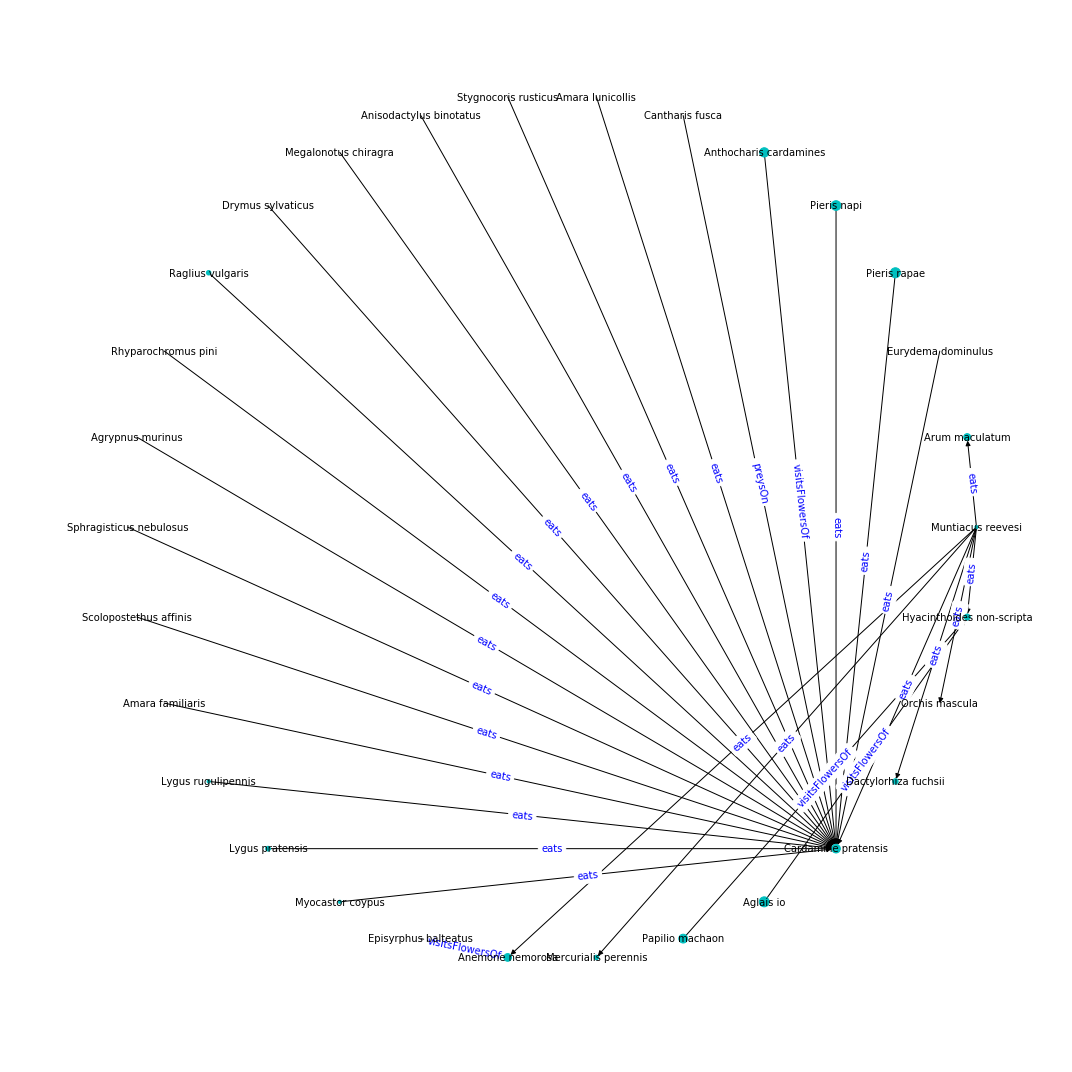

In [293]:
plt.figure(figsize=(15,15))
edge_labels = nx.get_edge_attributes(G,'label')

#pos = nx.spring_layout(G, iterations=50, k=50) 
#pos = nx.spring_layout(G)
#pos = nx.random_layout(G)
pos = nx.circular_layout(G)
#pos = nx.spectral_layout(G)
#pos = nx.shell_layout(G, scale=1)

nodeColors = nx.get_node_attributes(G,'color')

nx.draw_networkx_edge_labels(G,pos, edge_labels = edge_labels, font_size=10, font_color='blue')

#nx.draw_networkx_nodes(G, pos, node_color=nodeColors.values())

nx.draw_networkx(G, pos, with_labels=True, node_size = listOfNodeSizes, node_color='c', alpha= 1, arrows=True, 
                    linewidths=1, font_color="black", font_size=10, style = 'dashed')

plt.axis('off')
plt.tight_layout()
plt.show()

In [294]:
filename = "..\\docs\\"+taxon+country+".html"
with open(filename, "w") as file:
    file.write(" \
<!DOCTYPE html> \
<html> \
<head> \
<script src='../../../GitHub\cytoscape.js\dist\cytoscape.min.js'></script> \
<script src='https://unpkg.com/layout-base/layout-base.js'></script> \
<script src='https://unpkg.com/cose-base/cose-base.js'></script> \
<script src='../../../GitHub\cytoscape.js-cose-bilkent\cytoscape-cose-bilkent.js'></script> \
</head> \
<style>#cy {width: 90%; height: 90%; position: absolute; top: 50px; left: 150px;}\
body {font-family: 'times; font-size: 6px;}\
</style> \
<body> \
<h1><em font-style: italic;>"+taxon+"</em> in "+country+"</h1>")

### Write out the details of the species

In [295]:
with open(filename, "a") as file:
    if len(G.nodes)==0:
        file.write("<p>No interacting species have been found for "+taxon+" in "+country+".<br />") 
    else:
        file.write("<p>Nodes can be moved and if clicked on open a tab with species details<br />") 
        file.write("<p>The target species is red node. <em>Plantae</em> are green, <em>Animalia</em> are blue and everything else is brown<br />") 
        file.write("<p>Node area is proportional to the 1 km<sup>2</sup> occupancy<br />") 
    file.write("<p>All <a href='https://www.globalbioticinteractions.org/'>GloBI</a> interaction records that <em>"+taxon+"</em> has with other taxa</p>")
    

In [296]:
species = G.nodes
#with open(filename, "a") as file:
#    for n in species:
#        file.write("<tr><td><a target='_blank' href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a></td><td>"+str(dictOfNodeSizes[n])+"</td>\n")

In [297]:
with open(filename, "a") as file: 
    if len(sourceInteractions) != 0:
        file.write("<table><th>Interaction</th><th>number</th>")
        for n in sourceInteractions:
            file.write("<tr><td><a target='_blank' href=https://www.globalbioticinteractions.org/?interactionType="+str(n[0])+"&sourceTaxon="+taxon.replace(" ", "%20")+">"+str(n[0])+"</a></td><td>"+str(n[1])+"</td>\n")
        file.write("</table>") 
    if len(targetInteractions) != 0:
        file.write("<p>All <a href='https://www.globalbioticinteractions.org/'>GloBI</a> interaction records that other taxa have with <em>"+taxon+"</em></p>")
        file.write("<table><th>Interaction</th><th>number</th>")
        for n in targetInteractions:
            file.write("<tr><td><a target='_blank' href=https://www.globalbioticinteractions.org/?interactionType="+str(n[0])+"&targetTaxon="+taxon.replace(" ", "%20")+">"+str(n[0])+"</a></td><td>"+str(n[1])+"</td>\n") 
        file.write("</table>")  

In [298]:
file.close()

In [299]:
with open(filename, "a") as file:
    file.write(" \
<div id='cy'></div> \
<script> \
var cy = cytoscape({ \
  container: document.getElementById('cy'), \n \
  elements: [ \
")

### Write nodes to file

In [300]:
file = open(filename, "a")
for n in species:
    if n == taxon:
        file.write("{ data: { id: '"+n+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: true,},\n")
    else:
        file.write("{ data: { id: '"+n+"', kingdom: '"+kingdom[n]+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: false,},\n")
file.close()

### Write edges to file

In [301]:
file = open(filename, "a")
for edge in G.edges:
    file.write("{data: {id: '"+edge[0]+edge[1]+"', source: '"+edge[0]+"', target: '"+edge[1]+"', href: 'https://www.globalbioticinteractions.org/?interactionType="+str(nx.get_edge_attributes(G, 'label')[edge])+"&sourceTaxon="+edge[0]+"&targetTaxon="+edge[1]+"', label: '"+nx.get_edge_attributes(G, 'label')[edge]+"'}},\n")
file.close()
    

In [302]:
with open(filename, "a") as file:
    file.write("], \
style: [ \n\
        { \n\
            selector: 'node', \n\
            style: { \n\
                shape: 'circle', \n\
                'background-color': 'yellow', \n\
                label: 'data(id)', \n\
                'text-valign': 'center', \n\
                'font-family': 'helvetica', \n\
                'font-style': 'italic', \n\
                'font-size': '8px', \n\
                'border-width': '0.5', \n\
                'border-color': 'black', \n\
                'width': 'mapData(occnum, 0, 400, 3, 200)', \n\
                'height': 'mapData(occnum, 0, 400, 3, 200)' \n\
            } \n\
        },  \n\
        {  \n\
            selector: 'edge',  \n\
            style: {  \n\
                label: 'data(label)', \n\
                'font-family': 'helvetica', \n\
                'font-size': '6px', \n\
                'color': 'blue', \n\
                'curve-style': 'bezier', \n\
                'target-arrow-shape': 'triangle',  \n\
                'width': '1' \n\
                } \n\
         },  \n\
         {  \n\
              selector: '[kingdom = \"Plantae\"]',   \n\
              css: {  \n\
                'background-color': 'lightgreen'  \n\
                 }  \n\
        }, \n\
        {  \n\
              selector: '[kingdom = \"Animalia\"]',   \n\
              css: {  \n\
                'background-color': 'lightblue'  \n\
                 }  \n\
        }, \n\
        {  \n\
              selector: ':selected',   \n\
              css: {  \n\
                'line-color': 'red',  \n\
                'shape': 'square',  \n\
                'background-color': 'red'  \n\
                 }  \n\
        }], \n\
layout:  { \n\
            name: 'cose-bilkent', padding: 1, animate: true, gravity: 30, animationDuration: 3000 \n\
     } \n\
} \n\
); \n\
")

In [303]:
with open(filename, "a") as file:
    file.write("cy.userZoomingEnabled( true ); \n\
    cy.getElementById('"+taxon+"').select(); \n\
    document.write('<br />Degree of node <em>"+fullScientificName+"</em> = '+cy.getElementById('"+taxon+"').degree()); \n\
    cy.on('tap', 'node', function(){ \n\
        try { // your browser may block popups \n\
              window.open( this.data('href') ); \n\
            } catch(e){ // fall back on url change \n\
        window.location.href = this.data('href'); \n\
    } \n\
}); \n\
    cy.on('tap', 'edge', function(){  \n\
        try { // your browser may block popups  \n\
              window.open( this.data('href') );  \n\
            } catch(e){ // fall back on url change  \n\
        window.location.href = this.data('href'); \n\
    } \n\
}); \n\
</script> \n\
")

In [304]:
with open(filename, "a") as file:
    file.write("</ul> \
        </body> \
        </html>")

In [305]:
file.close()

In [306]:
#with open(filename, "a") as file:
#    file.write("<h2>References</h2><ul>\n")

In [307]:
citations = cleanInteractDataTaxon['sourceCitation'].unique()
#file = open(filename, "a")
for ref in citations:
    print("* ",str(ref))
#    file.write("<li>"+str(ref)+"</li>\n")
#file.close()

*  Food Webs and Species Interactions in the Biodiversity of UK and Ireland (Online). 2017. Data provided by Malcolm Storey. Also available from http://bioinfo.org.uk.
*  Stephens, P. R., Pappalardo, P. , Huang, S. , Byers, J. E., Farrell, M. J., Gehman, A. , Ghai, R. R., Haas, S. E., Han, B. , Park, A. W., Schmidt, J. P., Altizer, S. , Ezenwa, V. O. and Nunn, C. L. (2017), Global Mammal Parasite Database version 2.0. Ecology, 98: 1476-1476. doi:10.1002/ecy.1799
*  Ed Baker; Ian J. Kitching; George W. Beccaloni; Amoret Whitaker et al. (2016). Dataset: NHM Interactions Bank. Natural History Museum Data Portal (data.nhm.ac.uk). https://doi.org/10.5519/0060767
*  Sarah E Miller. 06/17/2015. Durden, Lance A., and Guy A. Musser. The Sucking Lice (Insecta, Anoplura) of the World : A Taxonomic Checklist with Records of Mammalian Hosts and Geographical Distributions. Bulletin of the AMNH ; No. 218. New York: American Museum of Natural History, 1994. Web.
*  Sarah E Miller. 4/18/2016. Species a

### For import into Gephi: A nodes and edges file has been replace by the .dot file format

In [308]:
write_dot(G, "..\\docs\\"+taxon+".dot")